#### Audio Classification Data Preprocessing

In [1]:
import librosa
import numba
import numpy as np
import tensorflow as tf
print("NumPy version:", np.__version__)
print("Numba version:", numba.__version__)
print("Tensorflow version:",tf.__version__)
print("Librosa version:",librosa.__version__)


NumPy version: 1.26.4
Numba version: 0.60.0
Tensorflow version: 2.18.0
Librosa version: 0.10.2.post1


In [2]:
### Let's read a sample audio using librosa
audio_file_path=r'C:\Users\pratik\Documents\Projects\audio_classification\UrbanSound8K\audio2\fold4\135528-6-4-2.wav'
librosa_audio_data,librosa_sample_rate=librosa.load(audio_file_path)

In [3]:
print(librosa_audio_data)

[ 0.1017779   0.09252265 -0.01029476 ...  0.28079608  0.26662326
  0.22703297]


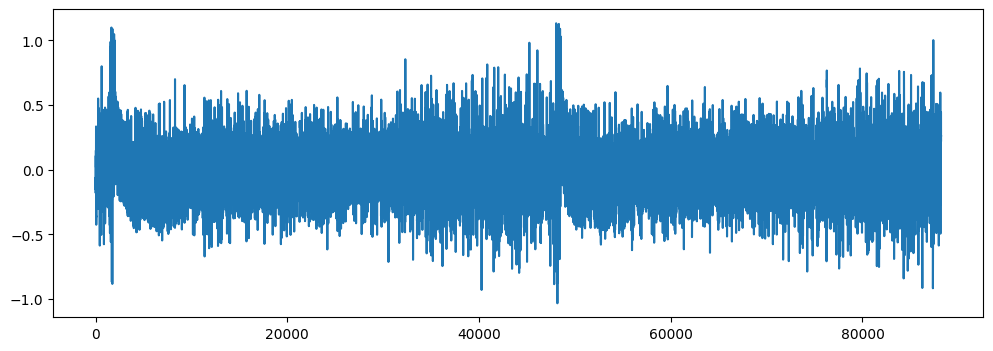

In [4]:
### Lets plot the librosa audio data
import matplotlib.pyplot as plt
# Original audio with 1 channel 
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)

#### Observation
Here Librosa converts the signal to mono, meaning the channel will alays be 1

In [5]:
### Lets read with scipy
from scipy.io import wavfile as wav
wave_sample_rate, wave_audio = wav.read(audio_file_path) 

In [6]:
wave_audio

array([[5318, 4033],
       [4459, 3127],
       [3304, 1978],
       ...,
       [8509, 7693],
       [7680, 6546],
       [6925, 5669]], dtype=int16)

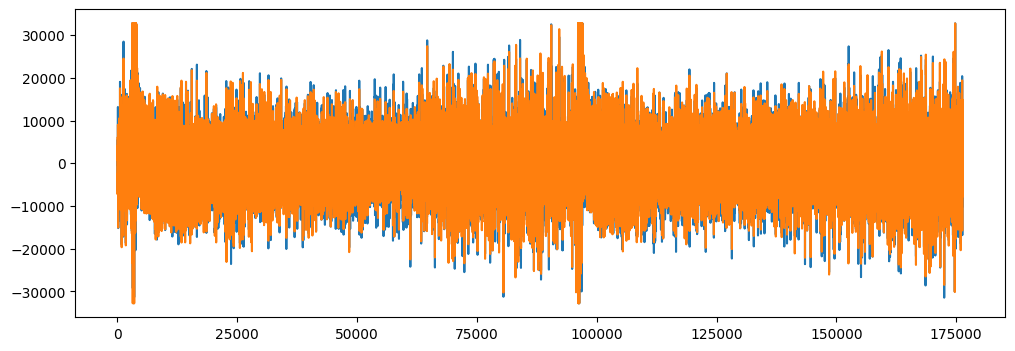

In [7]:
import matplotlib.pyplot as plt

# Original audio with 2 channels 
plt.figure(figsize=(12, 4))
plt.plot(wave_audio)

### Extract Features
Here we will be using Mel-Frequency Cepstral Coefficients(MFCC) from the audio 
samples.
The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. These audio representations will allow us to identify features for classification.

In [8]:
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 173)


In [9]:
mfccs

array([[-9.0757378e+01, -6.4957870e+01,  2.5701323e+01, ...,
        -3.1466866e+01, -3.4667324e+01, -5.0364735e+01],
       [ 1.7926300e+02,  1.9429706e+02,  1.0372595e+02, ...,
         1.8602203e+02,  1.8453941e+02,  1.6647110e+02],
       [-3.8887314e+01, -4.5582771e+01,  3.7404199e+00, ...,
        -3.6085999e+01, -2.9083427e+01, -2.3078842e+01],
       ...,
       [-1.1893944e+00, -9.9441946e-01,  4.5947523e+00, ...,
        -1.4260168e+00, -3.3234169e+00, -2.1230774e+00],
       [-2.9536514e+00, -6.3421688e+00, -1.1170663e+00, ...,
        -2.6557617e+00, -9.8496568e-01, -6.0143051e+00],
       [ 8.0156825e-02,  8.3574682e-01,  2.6181107e+00, ...,
        -1.2515843e+00,  2.3683586e+00, -1.1718901e+00]], dtype=float32)

In [10]:
#### Extracting MFCC's For every audio file
import pandas as pd
import os
import librosa

audio_dataset_path='UrbanSound8K/audio2/'
metadata=pd.read_csv('UrbanSound8K/metadata/metadata2.csv')
metadata.head()

,Unnamed: 0,slice_file_name,fsID,start,end,salience,fold,classID,class
0,0,100032-3-0-0.wav,100032.0,0.0,0.317551,1.0,5,3.0,dog_bark
1,1,100263-2-0-117.wav,100263.0,58.5,62.500000,1.0,5,2.0,children_playing
2,2,100263-2-0-121.wav,100263.0,60.5,64.500000,1.0,5,2.0,children_playing
3,3,100263-2-0-126.wav,100263.0,63.0,67.000000,1.0,5,2.0,children_playing
4,4,100263-2-0-137.wav,100263.0,68.5,72.500000,1.0,5,2.0,children_playing


In [11]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features,axis=1)
    
    return mfccs_scaled_features
    

In [12]:
import numpy as np
from tqdm import tqdm
### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

3554it [06:12, 16.57it/s]c:\Users\pratik\Documents\Projects\audio_classification\myenv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
8326it [10:36, 26.00it/s]c:\Users\pratik\Documents\Projects\audio_classification\myenv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
c:\Users\pratik\Documents\Projects\audio_classification\myenv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
9629it [11:32, 13.91it/s]


In [13]:
### converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-217.35526, 70.22339, -130.38527, -53.282898,...",dog_bark
1,"[-424.09818, 109.34077, -52.919525, 60.86475, ...",children_playing
2,"[-458.79114, 121.38419, -46.520657, 52.00812, ...",children_playing
3,"[-413.89984, 101.66371, -35.42945, 53.036358, ...",children_playing
4,"[-446.60352, 113.68541, -52.402218, 60.302044,...",children_playing


In [14]:
### Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [15]:
X.shape

(9629, 40)

In [16]:
y.shape

(9629,)

In [17]:
y

array(['dog_bark', 'children_playing', 'children_playing', ...,
       'laughter', 'laughter', 'laughter'], dtype='<U16')

In [19]:
### Label Encoding
###y=np.array(pd.get_dummies(y))
### Label Encoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [20]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [21]:
y.shape

(9629, 11)

In [22]:
### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [23]:
X_train

array([[-516.0193    ,   90.57641   ,   -5.9716887 , ...,    0.66494864,
           1.3720777 ,    0.7268819 ],
       [ -91.93015   ,   27.93474   ,  -42.40329   , ...,    4.0705447 ,
          -2.0685377 ,    1.2096168 ],
       [-100.50485   ,   75.717445  , -136.156     , ...,   -1.617378  ,
          -5.9498897 ,   -5.2066193 ],
       ...,
       [-427.01236   ,   92.62305   ,    3.1293974 , ...,    0.7426412 ,
           0.7334909 ,    0.71100914],
       [-145.75461   ,  136.26578   ,  -33.51552   , ...,    1.4681194 ,
          -2.00917   ,   -0.8821819 ],
       [-421.03134   ,  210.65454   ,    3.490661  , ...,   -5.3888674 ,
          -3.3713605 ,   -1.5665114 ]], dtype=float32)

In [24]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [25]:
X_train.shape

(7703, 40)

In [26]:
X_test.shape

(1926, 40)

In [27]:
y_train.shape

(7703, 11)

In [28]:
y_test.shape

(1926, 11)

### Model Creation

In [29]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [31]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [32]:
X_train.shape

(7703, 40, 1)

In [ ]:
# Model for 1D CNN
model = Sequential()

# First Conv1D Layer
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(40, 1)))  
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
# Second Conv1D Layer
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# Flatten and Fully Connected Layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='softmax'))

c:\Users\pratik\Documents\Projects\audio_classification\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 38, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 19, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 19, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 17, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,579 (615.54 KB)

 Trainable params: 157,579 (615.54 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)  # Stop if val_accuracy doesn't improve for 10 epochs
]


In [37]:
history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_test, y_test), 
    epochs=100,  
    batch_size=32, 
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1948 - loss: 3.2855 - val_accuracy: 0.4808 - val_loss: 1.6251
Epoch 2/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3876 - loss: 1.7482 - val_accuracy: 0.5862 - val_loss: 1.3158
Epoch 3/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4805 - loss: 1.5081 - val_accuracy: 0.6532 - val_loss: 1.1356
Epoch 4/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5320 - loss: 1.3665 - val_accuracy: 0.6921 - val_loss: 1.0034
Epoch 5/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5827 - loss: 1.2403 - val_accuracy: 0.7108 - val_loss: 0.9148
Epoch 6/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6051 - loss: 1.1551 - val_accuracy: 0.7207 - val_loss: 0.8434
Epoch 7/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6237 - loss: 1.0955 - val_accuracy: 0.7601 - val_loss: 0.7826
Epoch 8/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6505 - loss: 1.0200 - val_accu

In [38]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.9179646968841553


In [39]:
X_test[1]

array([[-4.1534687e+01],
       [ 1.3877066e+02],
       [-3.2865116e+01],
       [ 2.9767683e+01],
       [-6.2737298e+00],
       [ 2.8314939e+01],
       [-3.2349904e+00],
       [ 1.7749487e+01],
       [ 5.6441271e-01],
       [ 2.2663567e+01],
       [-5.5358326e-01],
       [ 1.7625053e+01],
       [-5.3487706e+00],
       [ 1.0334390e+01],
       [-3.3836613e+00],
       [ 1.0976203e+01],
       [-4.3231435e+00],
       [ 6.6230040e+00],
       [-1.3473388e+01],
       [-2.4449568e+00],
       [-6.8018990e+00],
       [ 7.4604154e-01],
       [-3.4486229e+00],
       [ 4.3100348e+00],
       [-2.2555852e+00],
       [ 2.4825635e+00],
       [-1.5194335e+00],
       [ 4.0157666e+00],
       [-3.6058474e+00],
       [ 5.5492663e+00],
       [ 2.3780377e+00],
       [ 4.1797681e+00],
       [-1.7252386e+00],
       [-5.0392127e-01],
       [-2.7605155e-02],
       [ 2.4627718e-01],
       [ 1.0648321e+00],
       [ 5.4801927e+00],
       [ 5.1341109e+00],
       [ 2.6659279e+00]],

In [40]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_classes

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


array([5, 5, 0, ..., 0, 6, 8], dtype=int64)

### Testing Some Test Audio Data

Steps
- Preprocess the new audio data
- predict the classes
- Invere transform your Predicted Label

In [41]:
filename = r"C:\Users\pratik\Documents\Projects\audio_classification\samples\drill-87927.mp3"
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast')

# Extract MFCC features
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features, axis=1)

# Reshape for Conv1D model
# Reshape to (1, time_steps, channels), where time_steps = 40 (n_mfcc)
mfccs_scaled_features = mfccs_scaled_features.reshape(1, 40, 1)  # Adding the channel dimension
print(mfccs_scaled_features.shape)

# Predict using the trained Conv1D model
y_pred = model.predict(mfccs_scaled_features)
print(y_pred)

# Get the predicted class
y_pred_classes = np.argmax(y_pred, axis=1)
print(y_pred_classes)

# Decode the predicted class label
prediction_class = labelencoder.inverse_transform(y_pred_classes)
print(prediction_class)

(1, 40, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
[[3.7619660e-03 5.4526936e-05 3.7442041e-03 1.3568415e-02 9.6184343e-01
  8.6856857e-03 1.6820598e-04 3.5844129e-03 5.8288588e-05 2.1727346e-03
  2.3581441e-03]]
[4]
['drilling']


In [42]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import seaborn as sns

In [43]:
y_testlab=np.argmax(y_test, axis=1)
y_testlab.shape

(1926,)

In [44]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_classes.shape

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


(1926,)

In [45]:
accuracy_score(y_testlab,y_pred_classes)

0.9179646936656283

<Axes: >

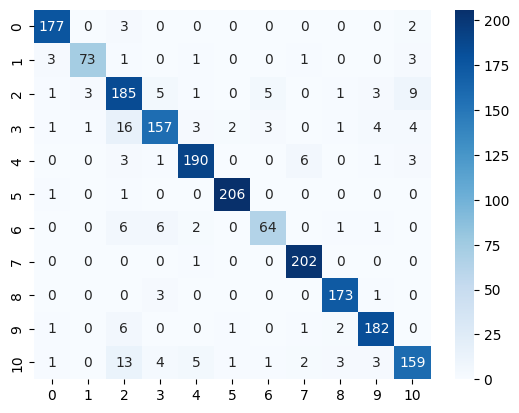

In [46]:
cm=confusion_matrix(y_testlab,y_pred_classes)
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')

In [47]:
class_names=labelencoder.classes_
class_names

array(['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
       'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'laughter',
       'siren', 'street_music'], dtype='<U16')

In [48]:
print(classification_report(y_testlab,y_pred_classes,target_names=class_names))

                  precision    recall  f1-score   support

 air_conditioner       0.96      0.97      0.96       182
        car_horn       0.95      0.89      0.92        82
children_playing       0.79      0.87      0.83       213
        dog_bark       0.89      0.82      0.85       192
        drilling       0.94      0.93      0.93       204
   engine_idling       0.98      0.99      0.99       208
        gun_shot       0.88      0.80      0.84        80
      jackhammer       0.95      1.00      0.97       203
        laughter       0.96      0.98      0.97       177
           siren       0.93      0.94      0.94       193
    street_music       0.88      0.83      0.85       192

        accuracy                           0.92      1926
       macro avg       0.92      0.91      0.91      1926
    weighted avg       0.92      0.92      0.92      1926



In [49]:
model.save(r'savedmodels\final_model_lnnn90.keras')

In [50]:
import pickle
with open('label_encoder_lnnn90.pkl', 'wb') as file:
    pickle.dump(labelencoder, file)

0 = air_conditioner
1 = car_horn
2 = children_playing
3 = dog_bark
4 = drilling
5 = engine_idling
6 = gun_shot
7 = jackhammer
8 = siren
9 = street_music